# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

2024-09-30 14:05:29.594408: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 14:05:30.124224: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 14:05:30.126666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 14:05:32.029774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

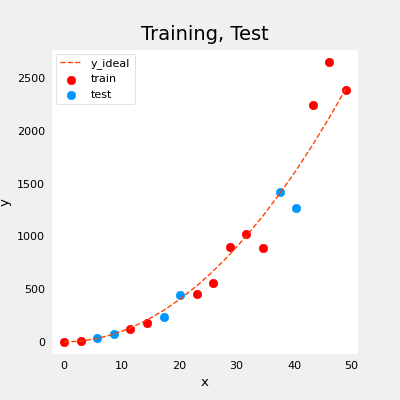

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err += (yhat[i] - y[i])**2
    err /= 2*m
    ### END CODE HERE ### 
    
    return(err)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [6]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [7]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

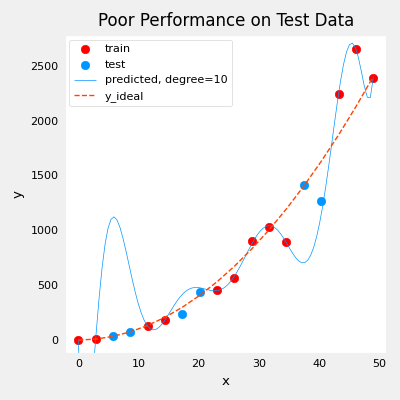

In [8]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [9]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

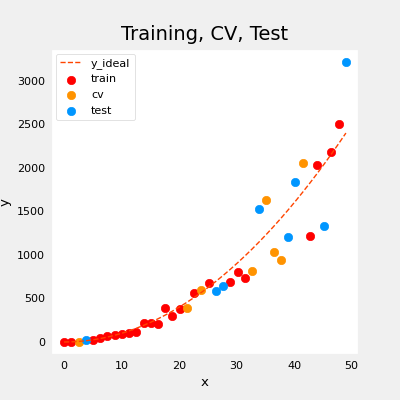

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [11]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

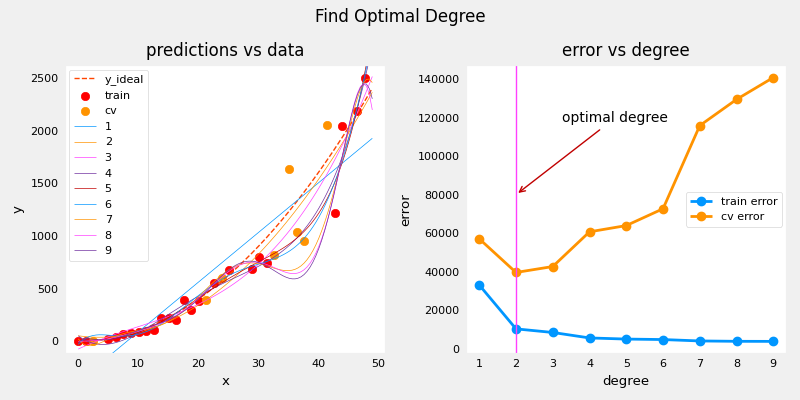

In [12]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [13]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

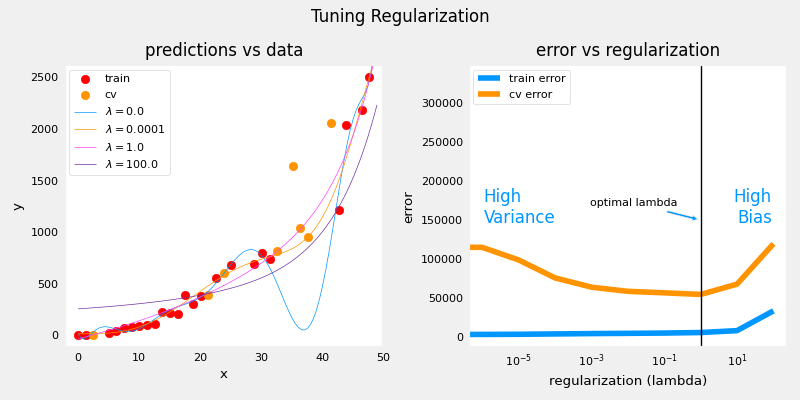

In [14]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

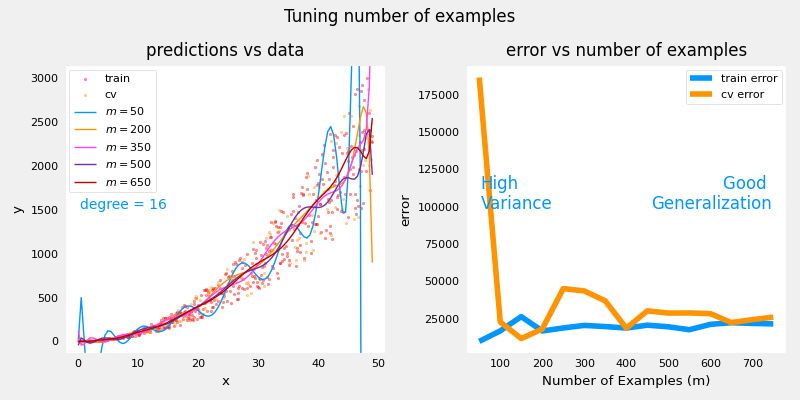

In [15]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [16]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


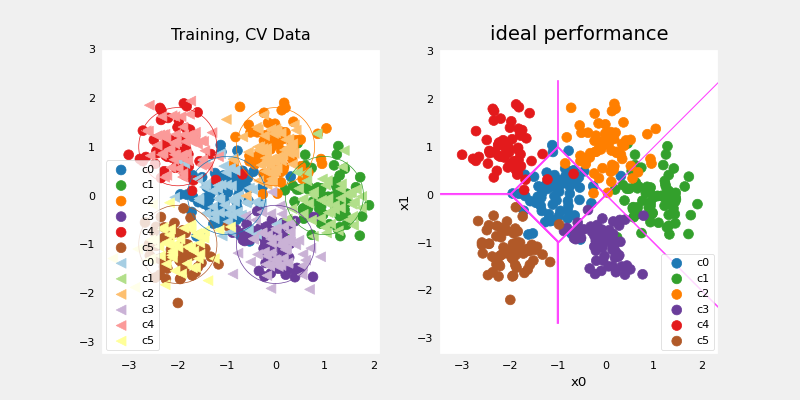

In [17]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [20]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if yhat[i] != y[i]:
            incorrect += 1
        cerr = incorrect/m
    ### END CODE HERE ### 
    
    return(cerr)

In [21]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [24]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=120, activation='relu'),
        Dense(units=40, activation='relu'),
        Dense(units=6, activation='linear'),
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=1e-2),
    ### END CODE HERE ### 
)

In [25]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 1s 7ms/step - loss: 1.0541
Epoch 2/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.4168
Epoch 3/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3159
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2775
Epoch 5/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.2656
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2926
Epoch 7/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2504
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2306
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2301
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2017
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2187
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2127
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.1638
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1611
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1884
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1648
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1492
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1582
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1612
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1496
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1428
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1421
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1479
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1508
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1179
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1008
Epoch 201/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0985
Epoch 202/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0956
Epoch 203/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0828
Epoch 204/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0894
Epoch 205/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0993
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1002
Epoch 207/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1036
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0958
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0933
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0936
Epoch 211/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0887
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0769
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0900
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0946
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1089
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1740
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1811
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1069
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1032
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0763
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0896
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0738
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1071
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0932
Epoch 397/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0728
Epoch 398/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 399/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0537
Epoch 400/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0552
Epoch 401/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0525
Epoch 402/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0558
Epoch 403/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0487
Epoch 404/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0679
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0892
Epoch 407/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0335
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0381
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0360
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0412
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1274
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1077
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0795
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0902
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0844
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0540
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0544
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0488
Epoch 593/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0601
Epoch 594/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0382
Epoch 595/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0401
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 597/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0371
Epoch 598/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0302
Epoch 599/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0317
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0388
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0345
Epoch 603/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0530
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0517
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0558
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0506
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0459
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0566
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0635
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0489
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0487
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0429
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0263
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 789/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0240
Epoch 790/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 791/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0293
Epoch 792/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0295
Epoch 793/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0285
Epoch 794/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0287
Epoch 795/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 796/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 797/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0224
Epoch 798/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 799/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1243
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0844
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0396
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0306
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0275
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0371
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0278
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0239
Epoch 985/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 986/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0234
Epoch 987/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0275
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 990/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0146
Epoch 995/1000
13/1

In [26]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 120)               360       
                                                                 
 dense_4 (Dense)             (None, 40)                4840      
                                                                 
 dense_5 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 2s 2ms/step


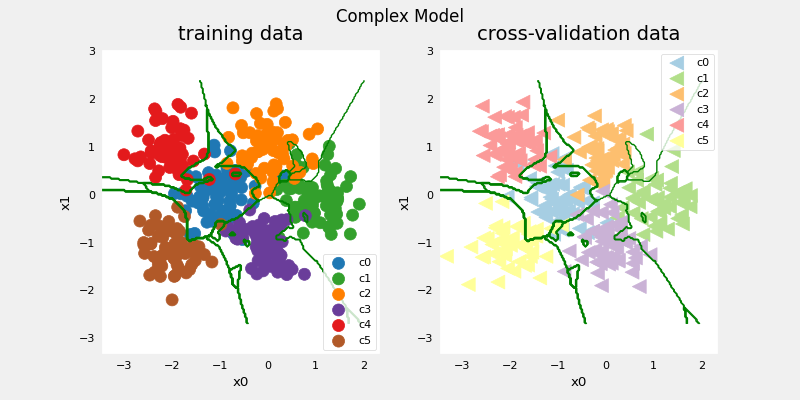

In [27]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [28]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 2ms/step
categorization error, training, complex model: 0.003
categorization error, cv,       complex model: 0.106


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [30]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=6, activation='relu'),
        Dense(units=6, activation='linear')
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=1e-2),
    ### START CODE HERE ### 
)


In [31]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 1s 5ms/step - loss: 1.8601
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.6274
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.4510
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.2484
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 1.0644
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9060
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.7828
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.6670
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5778
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.5110
Epoch 11/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4603
Epoch 12/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4264
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.1973
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1980
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2001
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1957
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1946
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1948
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1934
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1937
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1951
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1946
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1936
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1952
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1882
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1850
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1846
Epoch 202/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1832
Epoch 203/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1839
Epoch 204/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1847
Epoch 205/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1833
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1857
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1833
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1868
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1828
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1849
Epoch 211/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1832
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1825
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1809
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1814
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1813
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1846
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1802
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1864
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1815
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1797
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1806
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1814
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1778
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1809
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1825
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1792
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1787
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1806
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1790
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1793
Epoch 403/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1778
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1794
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1769
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1783
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1794
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1785
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1782
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1815
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1773
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1781
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1780
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1776
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1808
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1784
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1791
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1775
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1799
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 593/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1782
Epoch 594/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1771
Epoch 595/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1774
Epoch 597/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1783
Epoch 598/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1772
Epoch 599/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1764
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1797
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1769
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1785
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1765
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1761
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1773
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1776
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1771
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1772
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1766
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1770
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1793
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1768
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1772
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1777
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1795
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1755
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1764
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1790
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1748
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1760
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1792
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1815
Epoch 795/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1746
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1801
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1763
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1786
Epoch 799/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1763
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1755
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1783
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1765
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1757
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1788
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1758
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1774
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1761
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1774
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1767
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1767
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1772
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1755
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1746
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1779
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1760
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1774
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1773
Epoch 990/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1758
Epoch 991/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1763
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1769
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1757
Epoch 994/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1750
Epoch 995/1000
13/1

In [32]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 18        
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 2s 2ms/step


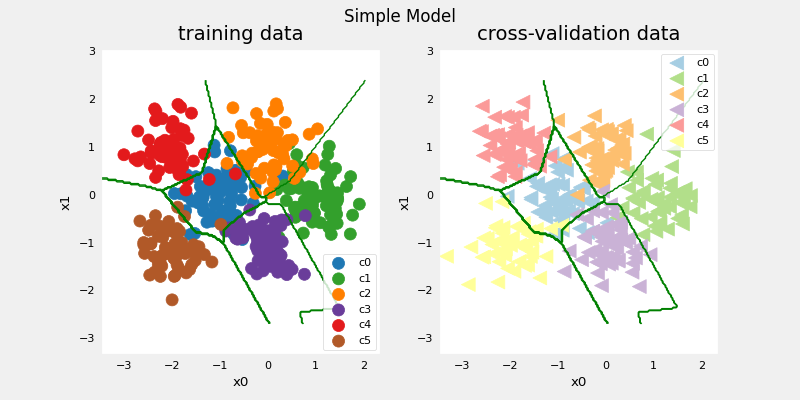

In [33]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [34]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 3ms/step
categorization error, training, simple model, 0.070, complex model: 0.003
categorization error, cv,       simple model, 0.062, complex model: 0.106


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [35]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=6, activation='linear'),
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=1e-2),
    ### START CODE HERE ### 
)


In [36]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 1s 6ms/step - loss: 4.4564
Epoch 2/1000
13/13 [==============================] - 0s 6ms/step - loss: 1.6668
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.3303
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0910
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 1.0178
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9515
Epoch 7/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.9629
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.9095
Epoch 9/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.8314
Epoch 10/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.7925
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7833
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7803
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.4742
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4618
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4650
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4552
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4829
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4393
Epoch 107/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4626
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4752
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4610
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4524
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4509
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4473
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4045
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4023
Epoch 201/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4217
Epoch 202/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3926
Epoch 203/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3959
Epoch 204/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4049
Epoch 205/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4480
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4247
Epoch 207/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4082
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4151
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4350
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4076
Epoch 211/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3811
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3939
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3919
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4277
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3964
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3918
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3816
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3751
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3772
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3858
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3896
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3914
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3813
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3744
Epoch 397/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3877
Epoch 398/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3740
Epoch 399/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3674
Epoch 400/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3693
Epoch 401/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3565
Epoch 402/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3580
Epoch 403/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3535
Epoch 404/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3558
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3507
Epoch 406/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3550
Epoch 407/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3450
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3494
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3448
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3655
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3850
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3422
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3363
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3603
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3556
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3576
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3804
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3632
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3408
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3386
Epoch 593/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3346
Epoch 594/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3323
Epoch 595/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4140
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3980
Epoch 597/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3521
Epoch 598/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3409
Epoch 599/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3312
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3479
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3296
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3360
Epoch 603/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3928
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3584
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3440
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3461
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3480
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3351
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3343
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3276
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3317
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3326
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3290
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3436
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3356
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3304
Epoch 789/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3377
Epoch 790/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3361
Epoch 791/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3707
Epoch 792/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3808
Epoch 793/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3648
Epoch 794/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3707
Epoch 795/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3373
Epoch 796/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3706
Epoch 797/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3169
Epoch 798/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3567
Epoch 799/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3387
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3177
Epoch 887/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3173
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3372
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3338
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3756
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3222
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3300
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3434
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3537
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3933
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3499
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3131
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3266
Epoch 985/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3250
Epoch 986/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3320
Epoch 987/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3288
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3091
Epoch 989/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3222
Epoch 990/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3244
Epoch 991/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3337
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3313
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3158
Epoch 994/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3121
Epoch 995/1000
13/1

In [37]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 120)               360       
                                                                 
 dense_9 (Dense)             (None, 40)                4840      
                                                                 
 dense_10 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 2s 2ms/step


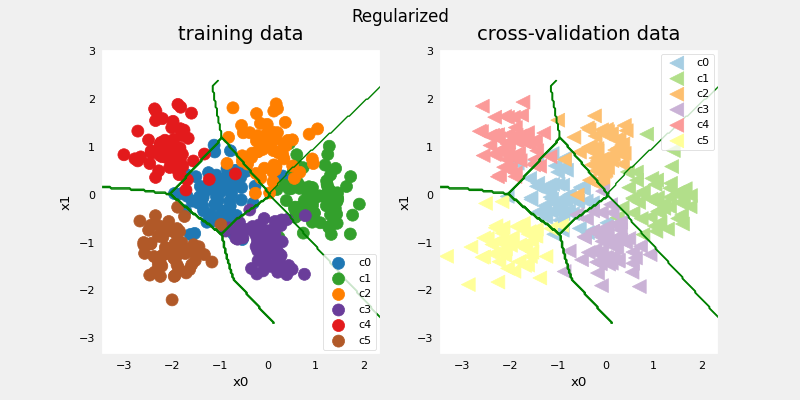

In [38]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [39]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 4ms/step
categorization error, training, regularized: 0.062, simple model, 0.070, complex model: 0.003
categorization error, cv,       regularized: 0.066, simple model, 0.062, complex model: 0.106


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [40]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 1s 5ms/step - loss: 1.0963
Epoch 2/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.4058
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3075
Epoch 4/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2841
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2865
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2923
Epoch 7/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2426
Epoch 8/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2216
Epoch 9/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2277
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1996
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2177
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2055
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 3ms/step - loss: 0.1820
Epoch 102/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1729
Epoch 103/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1849
Epoch 104/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1560
Epoch 105/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1424
Epoch 106/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1420
Epoch 107/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1523
Epoch 108/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1396
Epoch 109/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1373
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1314
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1527
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1475
Epoch 113/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1243
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1208
Epoch 201/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1161
Epoch 202/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1132
Epoch 203/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1168
Epoch 204/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1193
Epoch 205/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1048
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1014
Epoch 207/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0917
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1183
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0974
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1001
Epoch 211/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0755
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 299/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0750
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 301/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0513
Epoch 302/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 303/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0803
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0563
Epoch 305/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0645
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0523
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0761
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0561
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0430
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0532
Epoch 397/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0462
Epoch 398/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 399/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0452
Epoch 400/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0540
Epoch 401/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0713
Epoch 402/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0890
Epoch 403/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1112
Epoch 404/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0500
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0662
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0527
Epoch 407/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0486
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0417
Epoch 495/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0524
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0380
Epoch 497/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0297
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0323
Epoch 499/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0322
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0309
Epoch 501/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0398
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0342
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0312
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0321
Epoch 505/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0419
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0330
Epoch 593/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0407
Epoch 594/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 595/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0276
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0286
Epoch 597/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 598/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 599/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0290
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0318
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0372
Epoch 603/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0788
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1227
Epoch 691/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1110
Epoch 692/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1002
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0875
Epoch 694/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1207
Epoch 695/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1431
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1030
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0917
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 699/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0576
Epoch 700/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0520
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0388
Epoch 788/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0500
Epoch 789/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0757
Epoch 790/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1598
Epoch 791/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0975
Epoch 792/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0903
Epoch 793/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0852
Epoch 794/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 795/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0758
Epoch 796/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0539
Epoch 797/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0922
Epoch 798/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0827
Epoch 799/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0326
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0321
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0306
Epoch 889/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0344
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0400
Epoch 891/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0328
Epoch 892/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0308
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0278
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0320
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0264
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0302
Epoch 985/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0344
Epoch 986/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0337
Epoch 987/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0520
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0366
Epoch 989/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0364
Epoch 990/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0295
Epoch 991/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0560
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0906
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1563
Epoch 994/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1181
Epoch 995/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2446
Epoch 83/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2335
Epoch 84/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2342
Epoch 85/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2440
Epoch 86/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2255
Epoch 87/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2280
Epoch 88/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2408
Epoch 89/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2309
Epoch 90/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2257
Epoch 91/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2165
Epoch 92/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2150
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2209
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.2339
Epoch 182/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2104
Epoch 183/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2100
Epoch 184/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2036
Epoch 185/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2067
Epoch 186/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2045
Epoch 187/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2044
Epoch 188/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2045
Epoch 189/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2003
Epoch 190/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2113
Epoch 191/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2228
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2109
Epoch 193/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1995
Epoch 280/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2003
Epoch 281/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2031
Epoch 282/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1889
Epoch 283/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2161
Epoch 284/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1917
Epoch 285/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1878
Epoch 286/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1932
Epoch 287/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1912
Epoch 288/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2157
Epoch 289/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2032
Epoch 290/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2051
Epoch 291/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1805
Epoch 378/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1897
Epoch 379/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1840
Epoch 380/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1847
Epoch 381/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1829
Epoch 382/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1919
Epoch 383/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2070
Epoch 384/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1984
Epoch 385/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1879
Epoch 386/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1856
Epoch 387/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1856
Epoch 388/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1845
Epoch 389/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1847
Epoch 476/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1851
Epoch 477/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1911
Epoch 478/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1961
Epoch 479/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1776
Epoch 480/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1827
Epoch 481/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1782
Epoch 482/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1790
Epoch 483/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1792
Epoch 484/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1819
Epoch 485/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1749
Epoch 486/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1773
Epoch 487/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1770
Epoch 574/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1715
Epoch 575/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1678
Epoch 576/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1658
Epoch 577/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1728
Epoch 578/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1718
Epoch 579/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1687
Epoch 580/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1763
Epoch 581/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1731
Epoch 582/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1640
Epoch 583/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1661
Epoch 584/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1715
Epoch 585/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1590
Epoch 672/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1673
Epoch 673/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1637
Epoch 674/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1718
Epoch 675/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1721
Epoch 676/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1617
Epoch 677/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1646
Epoch 678/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1629
Epoch 679/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1819
Epoch 680/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1768
Epoch 681/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 682/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1830
Epoch 683/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1519
Epoch 770/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1569
Epoch 771/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1632
Epoch 772/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1551
Epoch 773/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1669
Epoch 774/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1688
Epoch 775/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1669
Epoch 776/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1556
Epoch 777/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1597
Epoch 778/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1649
Epoch 779/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1585
Epoch 780/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1594
Epoch 781/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1513
Epoch 868/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1639
Epoch 869/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1568
Epoch 870/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1620
Epoch 871/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1563
Epoch 872/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1486
Epoch 873/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1541
Epoch 874/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1456
Epoch 875/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1521
Epoch 876/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1529
Epoch 877/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1520
Epoch 878/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1556
Epoch 879/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1548
Epoch 966/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1512
Epoch 967/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1607
Epoch 968/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1611
Epoch 969/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1603
Epoch 970/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1549
Epoch 971/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1527
Epoch 972/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1473
Epoch 973/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1508
Epoch 974/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1529
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1481
Epoch 976/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1456
Epoch 977/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3725
Epoch 65/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3952
Epoch 66/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3527
Epoch 67/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3660
Epoch 68/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3583
Epoch 69/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3204
Epoch 70/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3118
Epoch 71/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3206
Epoch 72/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2988
Epoch 73/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3000
Epoch 74/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3072
Epoch 75/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3278
Epoch 76/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.2801
Epoch 164/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2933
Epoch 165/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2844
Epoch 166/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2812
Epoch 167/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2778
Epoch 168/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2830
Epoch 169/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2824
Epoch 170/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2822
Epoch 171/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2710
Epoch 172/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2659
Epoch 173/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2867
Epoch 174/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2842
Epoch 175/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2711
Epoch 262/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2640
Epoch 263/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2597
Epoch 264/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2530
Epoch 265/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2642
Epoch 266/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2680
Epoch 267/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2672
Epoch 268/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2581
Epoch 269/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2526
Epoch 270/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2614
Epoch 271/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2550
Epoch 272/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2601
Epoch 273/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2505
Epoch 360/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2695
Epoch 361/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2553
Epoch 362/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2786
Epoch 363/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2730
Epoch 364/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2574
Epoch 365/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2588
Epoch 366/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2646
Epoch 367/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2742
Epoch 368/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2601
Epoch 369/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2536
Epoch 370/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2530
Epoch 371/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2353
Epoch 458/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2551
Epoch 459/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2401
Epoch 460/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2413
Epoch 461/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2617
Epoch 462/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2378
Epoch 463/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2386
Epoch 464/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2431
Epoch 465/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2549
Epoch 466/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2532
Epoch 467/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2497
Epoch 468/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2499
Epoch 469/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2441
Epoch 556/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2305
Epoch 557/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2325
Epoch 558/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2366
Epoch 559/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2479
Epoch 560/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2527
Epoch 561/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2332
Epoch 562/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2562
Epoch 563/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2321
Epoch 564/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2411
Epoch 565/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2418
Epoch 566/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2441
Epoch 567/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2231
Epoch 654/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2430
Epoch 655/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2337
Epoch 656/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2336
Epoch 657/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2284
Epoch 658/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2466
Epoch 659/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2365
Epoch 660/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2395
Epoch 661/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2279
Epoch 662/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2437
Epoch 663/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2314
Epoch 664/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2516
Epoch 665/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2354
Epoch 752/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2370
Epoch 753/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2233
Epoch 754/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2395
Epoch 755/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2316
Epoch 756/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2402
Epoch 757/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2379
Epoch 758/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2301
Epoch 759/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2308
Epoch 760/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2295
Epoch 761/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2331
Epoch 762/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2288
Epoch 763/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2304
Epoch 850/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2241
Epoch 851/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2356
Epoch 852/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2537
Epoch 853/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2425
Epoch 854/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2379
Epoch 855/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2384
Epoch 856/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2221
Epoch 857/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2355
Epoch 858/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2349
Epoch 859/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2379
Epoch 860/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2311
Epoch 861/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2314
Epoch 948/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2290
Epoch 949/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2230
Epoch 950/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2202
Epoch 951/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2343
Epoch 952/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2404
Epoch 953/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2334
Epoch 954/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2372
Epoch 955/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2252
Epoch 956/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2278
Epoch 957/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2299
Epoch 958/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2405
Epoch 959/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4581
Epoch 47/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4291
Epoch 48/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4794
Epoch 49/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4660
Epoch 50/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4304
Epoch 51/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4479
Epoch 52/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4370
Epoch 53/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4489
Epoch 54/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4258
Epoch 55/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4538
Epoch 56/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4225
Epoch 57/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4389
Epoch 58/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.3578
Epoch 146/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3553
Epoch 147/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3838
Epoch 148/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3635
Epoch 149/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3578
Epoch 150/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3546
Epoch 151/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3549
Epoch 152/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3496
Epoch 153/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3760
Epoch 154/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3544
Epoch 155/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3556
Epoch 156/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3585
Epoch 157/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3302
Epoch 244/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3406
Epoch 245/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3411
Epoch 246/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3408
Epoch 247/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3280
Epoch 248/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3401
Epoch 249/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3495
Epoch 250/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3365
Epoch 251/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3633
Epoch 252/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3398
Epoch 253/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3380
Epoch 254/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3572
Epoch 255/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3271
Epoch 342/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3355
Epoch 343/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3243
Epoch 344/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3188
Epoch 345/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3180
Epoch 346/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3288
Epoch 347/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3335
Epoch 348/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3365
Epoch 349/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3085
Epoch 350/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3321
Epoch 351/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3153
Epoch 352/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3387
Epoch 353/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3081
Epoch 440/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3055
Epoch 441/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3132
Epoch 442/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3239
Epoch 443/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3170
Epoch 444/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3096
Epoch 445/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3199
Epoch 446/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3125
Epoch 447/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3407
Epoch 448/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3292
Epoch 449/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3074
Epoch 450/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3071
Epoch 451/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3637
Epoch 538/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3227
Epoch 539/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2958
Epoch 540/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3147
Epoch 541/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3254
Epoch 542/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3233
Epoch 543/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3133
Epoch 544/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3167
Epoch 545/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3064
Epoch 546/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3144
Epoch 547/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3336
Epoch 548/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3137
Epoch 549/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3305
Epoch 636/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3115
Epoch 637/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3060
Epoch 638/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2981
Epoch 639/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2950
Epoch 640/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2938
Epoch 641/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2912
Epoch 642/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3115
Epoch 643/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3213
Epoch 644/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2957
Epoch 645/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3153
Epoch 646/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3291
Epoch 647/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2983
Epoch 734/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3225
Epoch 735/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3123
Epoch 736/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3146
Epoch 737/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3228
Epoch 738/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2939
Epoch 739/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3054
Epoch 740/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3074
Epoch 741/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3209
Epoch 742/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3503
Epoch 743/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3014
Epoch 744/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2959
Epoch 745/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3059
Epoch 832/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3194
Epoch 833/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3265
Epoch 834/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2934
Epoch 835/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2950
Epoch 836/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2971
Epoch 837/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3044
Epoch 838/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3074
Epoch 839/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2943
Epoch 840/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3043
Epoch 841/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2901
Epoch 842/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3091
Epoch 843/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3100
Epoch 930/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3131
Epoch 931/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3047
Epoch 932/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2972
Epoch 933/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2976
Epoch 934/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3214
Epoch 935/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3073
Epoch 936/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2918
Epoch 937/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2862
Epoch 938/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3114
Epoch 939/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2930
Epoch 940/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2874
Epoch 941/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.6168
Epoch 29/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6096
Epoch 30/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6199
Epoch 31/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6220
Epoch 32/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6342
Epoch 33/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6280
Epoch 34/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6467
Epoch 35/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6384
Epoch 36/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6187
Epoch 37/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5873
Epoch 38/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5702
Epoch 39/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5754
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.4519
Epoch 128/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4400
Epoch 129/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4465
Epoch 130/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 131/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4728
Epoch 132/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4440
Epoch 133/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4309
Epoch 134/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4541
Epoch 135/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4470
Epoch 136/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4541
Epoch 137/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4376
Epoch 138/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4542
Epoch 139/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4359
Epoch 226/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4244
Epoch 227/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4390
Epoch 228/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3948
Epoch 229/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4059
Epoch 230/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4148
Epoch 231/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4048
Epoch 232/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4135
Epoch 233/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3932
Epoch 234/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3904
Epoch 235/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3916
Epoch 236/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3991
Epoch 237/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4101
Epoch 324/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4057
Epoch 325/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3971
Epoch 326/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3869
Epoch 327/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3786
Epoch 328/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3976
Epoch 329/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3794
Epoch 330/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3664
Epoch 331/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3712
Epoch 332/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3738
Epoch 333/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4097
Epoch 334/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3946
Epoch 335/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3815
Epoch 422/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3943
Epoch 423/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3728
Epoch 424/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3751
Epoch 425/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3632
Epoch 426/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3619
Epoch 427/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3633
Epoch 428/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3718
Epoch 429/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3689
Epoch 430/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3653
Epoch 431/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3536
Epoch 432/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3613
Epoch 433/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.3748
Epoch 520/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3691
Epoch 521/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3498
Epoch 522/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3621
Epoch 523/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3780
Epoch 524/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3403
Epoch 525/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3494
Epoch 526/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3557
Epoch 527/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3389
Epoch 528/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3445
Epoch 529/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3772
Epoch 530/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3639
Epoch 531/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3252
Epoch 618/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3654
Epoch 619/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3938
Epoch 620/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3857
Epoch 621/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3539
Epoch 622/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3552
Epoch 623/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3405
Epoch 624/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3297
Epoch 625/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3270
Epoch 626/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3405
Epoch 627/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3528
Epoch 628/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3674
Epoch 629/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3268
Epoch 716/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3342
Epoch 717/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3505
Epoch 718/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3726
Epoch 719/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4107
Epoch 720/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3917
Epoch 721/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3683
Epoch 722/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3475
Epoch 723/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3635
Epoch 724/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3476
Epoch 725/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3850
Epoch 726/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3565
Epoch 727/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3305
Epoch 814/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3354
Epoch 815/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3406
Epoch 816/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3434
Epoch 817/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3629
Epoch 818/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3546
Epoch 819/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3231
Epoch 820/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3629
Epoch 821/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3853
Epoch 822/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3431
Epoch 823/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3425
Epoch 824/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3478
Epoch 825/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3255
Epoch 912/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3251
Epoch 913/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3223
Epoch 914/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3457
Epoch 915/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3430
Epoch 916/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3512
Epoch 917/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3418
Epoch 918/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3341
Epoch 919/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3498
Epoch 920/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3671
Epoch 921/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3355
Epoch 922/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3424
Epoch 923/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 1.0460
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.0134
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9692
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9512
Epoch 13/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9520
Epoch 14/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9484
Epoch 15/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9016
Epoch 16/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9054
Epoch 17/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9034
Epoch 18/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8938
Epoch 19/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8698
Epoch 20/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8562
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5733
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5719
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5672
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5577
Epoch 113/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5508
Epoch 114/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5492
Epoch 115/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5509
Epoch 116/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5547
Epoch 117/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5873
Epoch 118/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5831
Epoch 119/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5743
Epoch 120/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5641
Epoc

13/13 [==============================] - 0s 3ms/step - loss: 0.5125
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5116
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5328
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5017
Epoch 211/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4998
Epoch 212/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4859
Epoch 213/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4861
Epoch 214/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4831
Epoch 215/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4892
Epoch 216/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5114
Epoch 217/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4939
Epoch 218/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4879
Epoch 219/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4531
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4807
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4597
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4455
Epoch 309/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4589
Epoch 310/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4523
Epoch 311/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4434
Epoch 312/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4445
Epoch 313/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4522
Epoch 314/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4557
Epoch 315/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4497
Epoch 316/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4427
Epoch 317/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4364
Epoch 404/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4422
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4240
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4256
Epoch 407/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4378
Epoch 408/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4484
Epoch 409/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4231
Epoch 410/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4456
Epoch 411/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4704
Epoch 412/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4272
Epoch 413/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4346
Epoch 414/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4454
Epoch 415/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4092
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4206
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4420
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4600
Epoch 505/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4510
Epoch 506/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4596
Epoch 507/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4578
Epoch 508/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4119
Epoch 509/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4154
Epoch 510/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4127
Epoch 511/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4279
Epoch 512/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4196
Epoch 513/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3962
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4146
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3928
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4034
Epoch 603/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3974
Epoch 604/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3979
Epoch 605/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4046
Epoch 606/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4283
Epoch 607/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4242
Epoch 608/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4258
Epoch 609/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4056
Epoch 610/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4312
Epoch 611/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3973
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4127
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3910
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3790
Epoch 701/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3950
Epoch 702/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3955
Epoch 703/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3758
Epoch 704/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4023
Epoch 705/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3995
Epoch 706/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4053
Epoch 707/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4199
Epoch 708/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3977
Epoch 709/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4514
Epoch 796/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4500
Epoch 797/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3879
Epoch 798/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3938
Epoch 799/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4021
Epoch 800/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3928
Epoch 801/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3786
Epoch 802/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3716
Epoch 803/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3696
Epoch 804/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3673
Epoch 805/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3858
Epoch 806/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3867
Epoch 807/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3979
Epoch 894/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3846
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4272
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3958
Epoch 897/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3944
Epoch 898/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3889
Epoch 899/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4161
Epoch 900/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3978
Epoch 901/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4250
Epoch 902/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4202
Epoch 903/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4182
Epoch 904/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3746
Epoch 905/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3822
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3628
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3728
Epoch 994/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3870
Epoch 995/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3825
Epoch 996/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3728
Epoch 997/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4100
Epoch 998/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3739
Epoch 999/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3902
Epoch 1000/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3928
Finished lambda = 0.2
Epoch 1/1000
13/13 [==============================] - 1s 3ms/step - loss: 10.0416
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 2.3062

13/13 [==============================] - 0s 3ms/step - loss: 0.7453
Epoch 91/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7288
Epoch 92/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7270
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7281
Epoch 94/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7235
Epoch 95/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7231
Epoch 96/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7137
Epoch 97/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7136
Epoch 98/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7185
Epoch 99/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7274
Epoch 100/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7293
Epoch 101/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7408
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5976
Epoch 190/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5971
Epoch 191/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6033
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5994
Epoch 193/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5855
Epoch 194/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5882
Epoch 195/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5834
Epoch 196/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5841
Epoch 197/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5934
Epoch 198/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5881
Epoch 199/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5933
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5934
Epoc

13/13 [==============================] - 0s 3ms/step - loss: 0.5475
Epoch 288/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5447
Epoch 289/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5455
Epoch 290/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5524
Epoch 291/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5543
Epoch 292/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5286
Epoch 293/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5406
Epoch 294/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5391
Epoch 295/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5535
Epoch 296/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5372
Epoch 297/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5316
Epoch 298/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5303
Epoch 299/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.5011
Epoch 386/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4868
Epoch 387/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4993
Epoch 388/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5123
Epoch 389/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5029
Epoch 390/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4841
Epoch 391/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4895
Epoch 392/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5018
Epoch 393/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4909
Epoch 394/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4875
Epoch 395/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5221
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5261
Epoch 397/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4998
Epoch 484/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4749
Epoch 485/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5113
Epoch 486/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4763
Epoch 487/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4810
Epoch 488/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4664
Epoch 489/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4500
Epoch 490/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4644
Epoch 491/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4807
Epoch 492/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4945
Epoch 493/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4771
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4648
Epoch 495/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4720
Epoch 582/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4688
Epoch 583/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4853
Epoch 584/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4744
Epoch 585/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4803
Epoch 586/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4756
Epoch 587/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4600
Epoch 588/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4463
Epoch 589/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4357
Epoch 590/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4568
Epoch 591/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4623
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4456
Epoch 593/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4386
Epoch 680/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4261
Epoch 681/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4497
Epoch 682/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4359
Epoch 683/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4400
Epoch 684/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4381
Epoch 685/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4452
Epoch 686/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4480
Epoch 687/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4347
Epoch 688/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4236
Epoch 689/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4790
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4564
Epoch 691/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4605
Epoch 778/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4587
Epoch 779/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4350
Epoch 780/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4296
Epoch 781/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4705
Epoch 782/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4318
Epoch 783/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4264
Epoch 784/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4257
Epoch 785/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4108
Epoch 786/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4167
Epoch 787/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4234
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4139
Epoch 789/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4109
Epoch 876/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4224
Epoch 877/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4251
Epoch 878/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4208
Epoch 879/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4130
Epoch 880/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4112
Epoch 881/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4089
Epoch 882/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4942
Epoch 883/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5079
Epoch 884/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4471
Epoch 885/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4414
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4146
Epoch 887/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4067
Epoch 974/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4125
Epoch 975/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4108
Epoch 976/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3999
Epoch 977/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4082
Epoch 978/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3929
Epoch 979/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4106
Epoch 980/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4273
Epoch 981/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4154
Epoch 982/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4018
Epoch 983/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3950
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4182
Epoch 985/1000
13/1

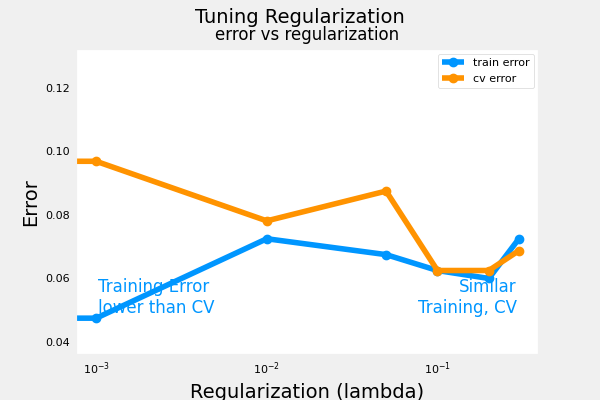

In [41]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

3/3 [==============================] - 0s 4ms/step


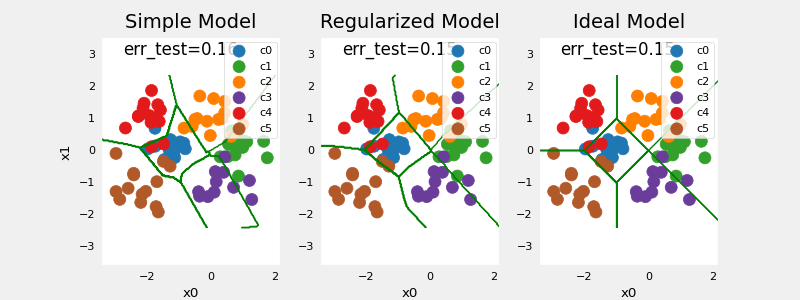

In [42]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)